In [ ]:
import requests
import wget

# Links to download files
urls = {
    'TCGA-KIRC.star_fpkm-uq.tsv.gz': 'https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-KIRC.star_fpkm-uq.tsv.gz',
    'KIRC_clinicalMatrix': 'https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.KIRC.sampleMap%2FKIRC_clinicalMatrix',
    'KIRC_survival.txt': 'https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/survival%2FKIRC_survival.txt'
}

for name, url in urls.items():
    if not os.path.exists(name):
        print(f"Downloading {name}...")
        # Using requests
        headers = {'User-Agent': 'Mozilla/5.0'}
        with requests.get(url, headers=headers, stream=True) as r:
            with open(name, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)

In [32]:
import pandas as pd
import numpy as np
import requests
import os
from lifelines import CoxPHFitter
from pingouin import partial_corr

# ==========================================
# 1. DATA ACQUISITION & FILE REPAIR
# ==========================================
urls = {
    'TCGA-KIRC.star_fpkm-uq.tsv.gz': 'https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-KIRC.star_fpkm-uq.tsv.gz',
    'KIRC_clinicalMatrix': 'https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.KIRC.sampleMap%2FKIRC_clinicalMatrix',
    'KIRC_survival.txt': 'https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/survival%2FKIRC_survival.txt'
}

print("Step 1: Checking and downloading files...")
headers = {'User-Agent': 'Mozilla/5.0'}
for name, url in urls.items():
    if not os.path.exists(name):
        alt_name = url.split('/')[-1]
        if os.path.exists(alt_name):
            os.rename(alt_name, name)
        else:
            print(f"Downloading {name}...")
            with requests.get(url, headers=headers, stream=True) as r:
                with open(name, 'wb') as f:
                    for chunk in r.iter_content(chunk_size=8192): f.write(chunk)

# Repair Xena filenames (remove %2F encoding)
for f in os.listdir('.'):
    if '%2F' in f:
        new_name = f.split('%2F')[-1]
        if not os.path.exists(new_name):
            os.rename(f, new_name)
            print(f"Renamed: {f} -> {new_name}")

# ==========================================
# 2. DATA LOADING & PREPROCESSING
# ==========================================
print("\nStep 2: Loading data into memory...")

# Gene Expression Data
df_exp_raw = pd.read_csv('TCGA-KIRC.star_fpkm-uq.tsv.gz', sep='\t')
df_exp_raw['Ensembl_ID'] = df_exp_raw['Ensembl_ID'].str.split('.', expand=True)[0]
gene_map = pd.read_excel('idmap.xlsx')
mapping_dict = dict(zip(gene_map['query'], gene_map['symbol']))
df_exp_raw['Symbol'] = df_exp_raw['Ensembl_ID'].map(mapping_dict)

# Transpose matrix: Rows = Samples, Columns = Genes
df_exp = df_exp_raw.dropna(subset=['Symbol']).drop_duplicates('Symbol').set_index('Symbol').drop(columns=['Ensembl_ID']).T
df_exp.index = df_exp.index.str[:12]

# Survival Data
survival = pd.read_csv('KIRC_survival.txt', sep='\t')
survival = survival.rename(columns={survival.columns[0]: 'sample_id'}).assign(sample_id=lambda x: x['sample_id'].str[:12])

# Clinical Metadata
clinical = pd.read_csv('KIRC_clinicalMatrix', sep='\t')
clinical = clinical.rename(columns={clinical.columns[0]: 'sample_id'}).assign(sample_id=lambda x: x['sample_id'].str[:12])

# Tumor Purity (ESTIMATE Score)
purity = None
if os.path.exists('KIRC_estimate_score.csv'):
    purity = pd.read_csv('KIRC_estimate_score.csv')
    purity = purity.rename(columns={purity.columns[0]: 'sample_id'}).assign(sample_id=lambda x: x['sample_id'].str[:12])
    print("Tumor purity data loaded successfully.")

# ==========================================
# 3. ANALYSIS PIPELINE: COX PH + PARTIAL CORR
# ==========================================
ceRNA_pairs = {
    'HSPA7': 'MIR6772',
    'RPS10P7': 'MIR155',
    'CTLA4': 'MIR6772'
}

print("\nStep 3: Running Statistical Analysis...")

for lnc, mir in ceRNA_pairs.items():
    try:
        print(f"\n{'-'*50}\nPAIR ANALYSIS: {lnc} and {mir}\n{'-'*50}")

        # Remove duplicates in gene list (essential for CTLA4 control)
        needed = list(set([lnc, 'CTLA4', mir]))

        # Verify gene availability
        missing = [g for g in needed if g not in df_exp.columns]
        if missing:
            print(f"Skipping: genes {missing} not found in expression matrix.")
            continue

        # Build master table 'm' for current pair
        m = df_exp[needed].reset_index().rename(columns={'index': 'sample_id'})
        m = m.merge(survival[['sample_id', 'OS', 'OS.time']], on='sample_id')
        m = m.merge(clinical[['sample_id', 'age_at_initial_pathologic_diagnosis', 'pathologic_stage']], on='sample_id')
        if purity is not None:
            m = m.merge(purity[['sample_id', 'ESTIMATE_score']], on='sample_id')

        # Variable Preparation (Log2 Transformation & Encoding)
        m['Lnc_Exp'] = np.log2(pd.to_numeric(m[lnc], errors='coerce') + 1)
        m['MiR_Exp'] = np.log2(pd.to_numeric(m[mir], errors='coerce') + 1)
        m['mRNA_Exp'] = np.log2(pd.to_numeric(m['CTLA4'], errors='coerce') + 1)
        m['Age'] = pd.to_numeric(m['age_at_initial_pathologic_diagnosis'], errors='coerce')
        m['Stage_High'] = m['pathologic_stage'].apply(lambda x: 1 if str(x) in ['Stage III', 'Stage IV'] else 0)

        # --- COX PH REGRESSION ---
        print("\n[Cox PH Model Results]")
        cox_cols = ['OS', 'OS.time', 'Lnc_Exp', 'Age', 'Stage_High']
        if purity is not None: cox_cols.append('ESTIMATE_score')

        df_cox = m[cox_cols].dropna()
        if not df_cox.empty:
            cph = CoxPHFitter()
            cph.fit(df_cox, duration_col='OS.time', event_col='OS')
            print(cph.summary[['exp(coef)', 'p']])

        # --- PARTIAL CORRELATION (ceRNA Mechanism) ---
        print(f"\n[Partial Correlation: {mir} vs CTLA4]")
        covars = ['Lnc_Exp']
        if purity is not None: covars.append('ESTIMATE_score')

        # Variance Check (to prevent NaN results)
        df_corr = m.dropna(subset=['MiR_Exp', 'mRNA_Exp'] + covars)
        if df_corr['MiR_Exp'].var() == 0 or df_corr['mRNA_Exp'].var() == 0:
            print("Insufficient variance in data to calculate correlation.")
        else:
            res_corr = partial_corr(data=df_corr, x='MiR_Exp', y='mRNA_Exp', covar=covars, method='spearman')
            print(res_corr[['n', 'r', 'p-val']])

    except Exception as e:
        print(f"Error during analysis of {lnc}: {e}")

print("\n--- ALL ANALYSES COMPLETED ---")

Step 1: Checking and downloading files...

Step 2: Loading data into memory...

Step 3: Running Statistical Analysis...

--------------------------------------------------
PAIR ANALYSIS: HSPA7 and MIR6772
--------------------------------------------------

[Cox PH Model Results]
            exp(coef)             p
covariate                          
Lnc_Exp      1.541305  5.723563e-15
Age          1.036415  2.242349e-28
Stage_High   3.314807  2.107107e-54

[Partial Correlation: MIR6772 vs CTLA4]
             n         r         p-val
spearman  2053 -0.242443  7.801217e-29

--------------------------------------------------
PAIR ANALYSIS: RPS10P7 and MIR155
--------------------------------------------------

[Cox PH Model Results]
            exp(coef)             p
covariate                          
Lnc_Exp      2.113339  1.265215e-09
Age          1.037111  4.871162e-29
Stage_High   3.283171  1.329902e-53

[Partial Correlation: MIR155 vs CTLA4]
Insufficient variance in data to calcula

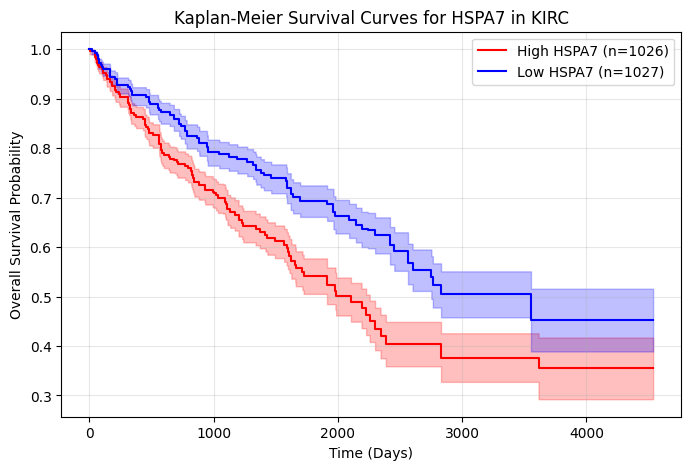

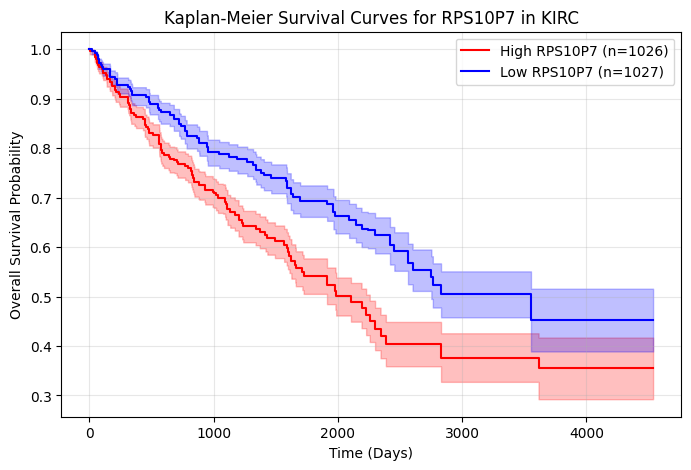

In [33]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

def plot_km_curves(gene, df_m):
    kmf = KaplanMeierFitter()

    # Разделяем по медиане
    median_val = df_m['Lnc_Exp'].median()
    high_group = df_m[df_m['Lnc_Exp'] > median_val]
    low_group = df_m[df_m['Lnc_Exp'] <= median_val]

    plt.figure(figsize=(8, 5))

    # Рисуем кривые
    kmf.fit(high_group['OS.time'], high_group['OS'], label=f'High {gene} (n={len(high_group)})')
    ax = kmf.plot_survival_function(ci_show=True, color='red')

    kmf.fit(low_group['OS.time'], low_group['OS'], label=f'Low {gene} (n={len(low_group)})')
    kmf.plot_survival_function(ax=ax, ci_show=True, color='blue')

    plt.title(f'Kaplan-Meier Survival Curves for {gene} in KIRC')
    plt.xlabel('Time (Days)')
    plt.ylabel('Overall Survival Probability')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

# Запуск визуализации для твоих генов
# (Нужно запустить после основного цикла, где создается таблица m)
for gene in ['HSPA7', 'RPS10P7']:
    try:
        # Берем данные из последнего успешного объединения для конкретного гена
        plot_km_curves(gene, m)
    except:
        print(f"Could not plot KM for {gene}")